In [155]:
import os
from medpy.io import load
import numpy as np
import cv2 as cv

PATH = os.path.join(os.path.dirname(os.path.abspath('__file__')), "../../CSE700/DCGAN/SampleData/Image_Data/")

def pad_image(img, desired_shape=(256, 256)):
    pad_top = 0
    pad_bot = 0
    pad_left = 0
    pad_right = 0
    if desired_shape[0] > img.shape[0]:
        pad_top = int((desired_shape[0] - img.shape[0]) / 2)
        pad_bot = desired_shape[0] - img.shape[0] - pad_top
    if desired_shape[1] > img.shape[1]:
        pad_left = int((desired_shape[1] - img.shape[1]) / 2)
        pad_right = desired_shape[1] - img.shape[1] - pad_left
    img = np.pad(img, ((pad_top, pad_bot), (pad_left, pad_right)), 'constant')
    assert (img.shape == desired_shape)
    return img


def normalize(img):
    nimg = None
    nimg = cv.normalize(img, nimg, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)
    nimg = pad_image(nimg, desired_shape=(256, 256))
    return nimg


def load_single_image(path):
    for dir, subdir, files in os.walk(path):
        for file in files:
            if file.endswith(".mha"):
                img = load_itk(os.path.join(path, file))
                return img


def create_1_chan_data(flair, ot):
    ot_layers = []
    flair_layers = []
    for layer in range(ot.shape[2]):
        ot_layers.append(pad_image(ot[:, :, layer], desired_shape=(256, 256)))
        flair_layers.append(normalize(flair[:, :, layer]))

    return np.stack(ot_layers, axis=0), np.stack(flair_layers, axis=0)


def load_dataset(path):
    
    train_flair = []
    train_ot = []

    for dir in os.listdir(path):
        if dir == 'HG':
            HG_path = os.path.join(path, 'HG')
            for dir2 in os.listdir(HG_path):
                if dir2 != '.DS_Store':
                    HG_flair = load_single_image(os.path.join(HG_path, dir2, 'VSD.Brain.XX.O.MR_Flair'))
                    HG_ot = load_single_image(os.path.join(HG_path, dir2, 'VSD.Brain_3more.XX.XX.OT'))
                    assert (HG_ot.shape == HG_flair.shape )
                    HG_samples = create_1_chan_data(HG_flair, HG_ot)
                    train_ot.append(HG_samples[0])
                    train_flair.append(HG_samples[1])

        if dir == 'LG':
            brain_1 = brain_2 = brain_3 = False
            LG_path = os.path.join(path, 'LG')
            for dir3 in os.listdir(LG_path):
                if dir3 != '.DS_Store':
                    LG_flair = load_single_image(os.path.join(LG_path, dir3, 'VSD.Brain.XX.O.MR_Flair'))
                    brain_1 = os.path.exists(os.path.join(LG_path, dir3, 'VSD.Brain_1more.XX.XX.OT'))
                    brain_2 = os.path.exists(os.path.join(LG_path, dir3, 'VSD.Brain_2more.XX.XX.OT'))
                    brain_3 = os.path.exists(os.path.join(LG_path, dir3, 'VSD.Brain_3more.XX.XX.OT'))
                    if brain_1:
                        LG_ot = load_single_image(os.path.join(LG_path, dir3, 'VSD.Brain_1more.XX.XX.OT'))
                    if brain_2:
                        LG_ot = load_single_image(os.path.join(LG_path, dir3, 'VSD.Brain_2more.XX.XX.OT'))
                    if brain_3:
                        LG_ot = load_single_image(os.path.join(LG_path, dir3, 'VSD.Brain_3more.XX.XX.OT'))

                    assert (LG_ot.shape == LG_flair.shape)
                    LG_samples = create_1_chan_data(LG_flair, LG_ot)
                    train_ot.append(LG_samples[0])
                    train_flair.append(LG_samples[1])
    # Stacking all individual layers
    train_ot = np.vstack(train_ot)
    train_flair = np.vstack(train_flair)
    assert (train_ot.shape == train_flair.shape)
    return np.array([train_flair,train_ot])

In [156]:
import SimpleITK as sitk
import numpy as np
import os
import glob
from medpy.io import load
'''
This funciton reads a '.mhd' file using SimpleITK and return the image array, origin and spacing of the image.
'''

def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))

    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))

#     return ct_scan, origin, spacing
    return ct_scan

In [99]:
x =load_dataset(PATH)

In [157]:
print(x.shape)

(2, 5417, 256, 256)


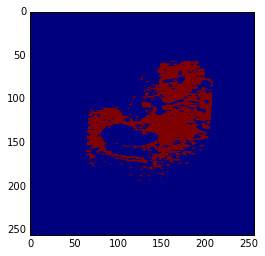

In [158]:
import matplotlib.pyplot as plt
# fig1 = plt.figure()
plt.imshow(x[0,100,:,:])
plt.savefig('sample.png')


In [102]:
print(x[1,100,:,:].shape)

(256, 256)


In [103]:
imginput = x[0]
imgoutput = x[1]

In [104]:
print(imginput.shape)

(5417, 256, 256)


In [105]:
print(imgoutput.shape)

(5417, 256, 256)


In [202]:
import numpy as np
np.amax(imgoutput)

4

In [107]:
x[0,1].shape

(256, 256)

In [108]:
np.unique(x[0,89])

array([0, 1], dtype=int16)

In [215]:
np.unique(x[1,89])

array([0, 2, 3, 4], dtype=int16)

# Experiment

In [120]:
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
from PIL import Image
import numpy as np

# Image configuration
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
data_files = PATH
shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT,1


In [121]:
def get_batches(batch_size):
    """
    Generate batches
    """
    IMAGE_MAX_VALUE = 255


    current_index = 0
    while current_index + batch_size <= shape[0]:

        data_batch = (x[0,current_index:current_index + batch_size])
        print(type(data_batch))
        print(data_batch.shape)
        data_batch = data_batch[...,np.newaxis]
        print(data_batch.shape)
        

#         np.vstack((data_batch, x[1,current_index:current_index + batch_size]))
        
        

        current_index += batch_size
        
#         return data_batch / IMAGE_MAX_VALUE - 0.5
        
#         yield data_batch / IMAGE_MAX_VALUE - 0.5
        print("db:",data_batch.shape)
        yield data_batch

In [200]:
print(get_batches(4))

<generator object get_batches at 0x13397b888>


In [201]:
import tensorflow as tf

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    """
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

In [170]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    """
    alpha = 0.2
    print("image size:",images.shape)
    with tf.variable_scope('discriminator', reuse=reuse):
        # using 4 layer network as in DCGAN Paper
        
        # Conv 1
        conv1 = tf.layers.conv2d(images, 64, 5, 2, 'SAME')
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        print("layer1:",lrelu1.shape)
        
        # Conv 2
        conv2 = tf.layers.conv2d(lrelu1, 128, 5, 2, 'SAME')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        print("layer2:",lrelu2.shape)

        # Conv 3
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, 1, 'SAME')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        print("layer3:",lrelu3.shape)

        # Flatten
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        print("layer4:",flat.shape)
        
        # Logits
        logits = tf.layers.dense(flat, 1)
        
        # Output
        out = tf.sigmoid(logits)
        
        return out, logits

In [183]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    """
    alpha = 0.2
    print("gen,z:",z.shape)
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        # First fully connected layer
        x_1 = tf.layers.dense(z, 32*32*512)
        print("Gen,fully conn layer 1:",x_1.shape)
        
        # Reshape it to start the convolutional stack
        deconv_2 = tf.reshape(x_1, (-1, 32, 32, 512))
        batch_norm2 = tf.layers.batch_normalization(deconv_2, training=is_train)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        print("Gen,fully conn layer 1 reshape:",lrelu2.shape)

        
        # Deconv 1
        deconv3 = tf.layers.conv2d_transpose(lrelu2, 256, 5, 2, padding='SAME')
        batch_norm3 = tf.layers.batch_normalization(deconv3, training=is_train)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        print("Gen,deconv layer 1 :",lrelu3.shape)

        
        # Deconv 2
        deconv4 = tf.layers.conv2d_transpose(lrelu3, 128, 5, 2, padding='SAME')
        batch_norm4 = tf.layers.batch_normalization(deconv4, training=is_train)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
        print("Gen,deconv layer 2 :",lrelu4.shape)

        # Output layer
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 5, 2, padding='SAME')
        print("Gen,output layer :",logits.shape)

        out = tf.tanh(logits)
        
        return out

In [184]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    """
    
    label_smoothing = 0.9
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    print("gmodel size", g_model.shape)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real) * label_smoothing))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
                                                  
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake) * label_smoothing))
    
    
    return d_loss, g_loss

In [185]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

In [225]:
def images_square_grid(images, mode='L'):
    """
    Helper function to save images as a square grid (visualization)
    """
    print(images.shape)
    image_rep = images.reshape((images.shape[1],images.shape[2]))
    print(image_rep.shape)
    
    # Get maximum size for square grid of images
    save_size = math.floor(np.sqrt(images.shape[0]))
    # Scale to 0-255
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)
    # Put images in a square arrangement
    images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image_rep, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im

def show_generator_output(sess, n_images, input_z, out_channel_dim):
    """
    Show example output for the generator
    """
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    pyplot.imshow(images_square_grid(samples))
    pyplot.show()

In [226]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape):
    """
    Train the GAN
    """
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # values range from -0.5 to 0.5, therefore scale to range -1, 1
                batch_images = batch_images * 2
                steps += 1
            
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                print("Batch:",batch_images.shape)
                print("Batch Z:",batch_z.shape)


                
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps % 1 == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    print("Reached inside condition:steps % 1 ==0")
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    print("datashape3:",data_shape[3])
                    
                    _ = show_generator_output(sess, 1, input_z, data_shape[3])

gen,z: (?, 1)
Gen,fully conn layer 1: (?, 524288)
Gen,fully conn layer 1 reshape: (?, 32, 32, 512)
Gen,deconv layer 1 : (?, 64, 64, 256)
Gen,deconv layer 2 : (?, 128, 128, 128)
Gen,output layer : (?, 256, 256, 1)
image size: (?, 256, 256, 1)
layer1: (?, 128, 128, 64)
layer2: (?, 64, 64, 128)
layer3: (?, 64, 64, 256)
layer4: (?, 4096)
gmodel size (?, 256, 256, 1)
image size: (?, 256, 256, 1)
layer1: (?, 128, 128, 64)
layer2: (?, 64, 64, 128)
layer3: (?, 64, 64, 256)
layer4: (?, 4096)
<class 'numpy.ndarray'>
(5, 256, 256)
(5, 256, 256, 1)
db: (5, 256, 256, 1)
Batch: (5, 256, 256, 1)
Batch Z: (5, 1)
Reached inside condition:steps % 1 ==0
Epoch 1/2... Discriminator Loss: 5.4363... Generator Loss: 0.4894
datashape3: 1
gen,z: (?, 1)
Gen,fully conn layer 1: (?, 524288)
Gen,fully conn layer 1 reshape: (?, 32, 32, 512)
Gen,deconv layer 1 : (?, 64, 64, 256)
Gen,deconv layer 2 : (?, 128, 128, 128)
Gen,output layer : (?, 256, 256, 1)
(1, 256, 256, 1)
(256, 256)


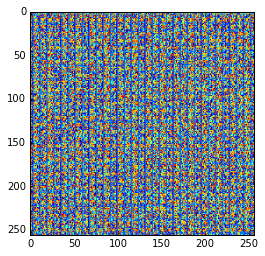

<class 'numpy.ndarray'>
(5, 256, 256)
(5, 256, 256, 1)
db: (5, 256, 256, 1)
Batch: (5, 256, 256, 1)
Batch Z: (5, 1)
Reached inside condition:steps % 1 ==0
Epoch 1/2... Discriminator Loss: 3.9961... Generator Loss: 0.3755
datashape3: 1
gen,z: (?, 1)
Gen,fully conn layer 1: (?, 524288)
Gen,fully conn layer 1 reshape: (?, 32, 32, 512)
Gen,deconv layer 1 : (?, 64, 64, 256)
Gen,deconv layer 2 : (?, 128, 128, 128)
Gen,output layer : (?, 256, 256, 1)
(1, 256, 256, 1)
(256, 256)


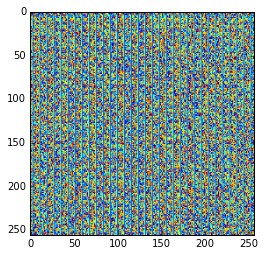

<class 'numpy.ndarray'>
(5, 256, 256)
(5, 256, 256, 1)
db: (5, 256, 256, 1)
Batch: (5, 256, 256, 1)
Batch Z: (5, 1)
Reached inside condition:steps % 1 ==0
Epoch 1/2... Discriminator Loss: 2.6718... Generator Loss: 0.3649
datashape3: 1
gen,z: (?, 1)
Gen,fully conn layer 1: (?, 524288)
Gen,fully conn layer 1 reshape: (?, 32, 32, 512)
Gen,deconv layer 1 : (?, 64, 64, 256)
Gen,deconv layer 2 : (?, 128, 128, 128)
Gen,output layer : (?, 256, 256, 1)
(1, 256, 256, 1)
(256, 256)


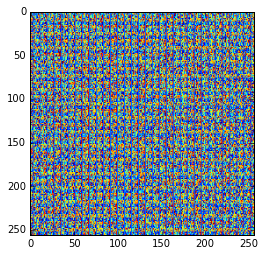

<class 'numpy.ndarray'>
(5, 256, 256)
(5, 256, 256, 1)
db: (5, 256, 256, 1)
Batch: (5, 256, 256, 1)
Batch Z: (5, 1)
Reached inside condition:steps % 1 ==0
Epoch 1/2... Discriminator Loss: 2.3274... Generator Loss: 0.4146
datashape3: 1
gen,z: (?, 1)
Gen,fully conn layer 1: (?, 524288)
Gen,fully conn layer 1 reshape: (?, 32, 32, 512)
Gen,deconv layer 1 : (?, 64, 64, 256)
Gen,deconv layer 2 : (?, 128, 128, 128)
Gen,output layer : (?, 256, 256, 1)
(1, 256, 256, 1)
(256, 256)


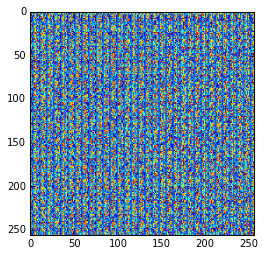

<class 'numpy.ndarray'>
(5, 256, 256)
(5, 256, 256, 1)
db: (5, 256, 256, 1)
Batch: (5, 256, 256, 1)
Batch Z: (5, 1)
Reached inside condition:steps % 1 ==0
Epoch 1/2... Discriminator Loss: 3.0795... Generator Loss: 0.3558
datashape3: 1
gen,z: (?, 1)
Gen,fully conn layer 1: (?, 524288)
Gen,fully conn layer 1 reshape: (?, 32, 32, 512)
Gen,deconv layer 1 : (?, 64, 64, 256)
Gen,deconv layer 2 : (?, 128, 128, 128)
Gen,output layer : (?, 256, 256, 1)
(1, 256, 256, 1)
(256, 256)


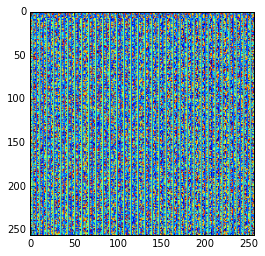

<class 'numpy.ndarray'>
(5, 256, 256)
(5, 256, 256, 1)
db: (5, 256, 256, 1)
Batch: (5, 256, 256, 1)
Batch Z: (5, 1)
Reached inside condition:steps % 1 ==0
Epoch 1/2... Discriminator Loss: 3.0295... Generator Loss: 0.3566
datashape3: 1
gen,z: (?, 1)
Gen,fully conn layer 1: (?, 524288)
Gen,fully conn layer 1 reshape: (?, 32, 32, 512)
Gen,deconv layer 1 : (?, 64, 64, 256)
Gen,deconv layer 2 : (?, 128, 128, 128)
Gen,output layer : (?, 256, 256, 1)
(1, 256, 256, 1)
(256, 256)


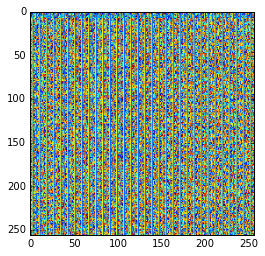

<class 'numpy.ndarray'>
(5, 256, 256)
(5, 256, 256, 1)
db: (5, 256, 256, 1)
Batch: (5, 256, 256, 1)
Batch Z: (5, 1)
Reached inside condition:steps % 1 ==0
Epoch 1/2... Discriminator Loss: 2.6539... Generator Loss: 0.3891
datashape3: 1
gen,z: (?, 1)
Gen,fully conn layer 1: (?, 524288)
Gen,fully conn layer 1 reshape: (?, 32, 32, 512)
Gen,deconv layer 1 : (?, 64, 64, 256)
Gen,deconv layer 2 : (?, 128, 128, 128)
Gen,output layer : (?, 256, 256, 1)
(1, 256, 256, 1)
(256, 256)


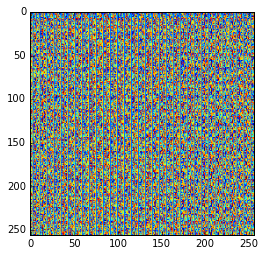

<class 'numpy.ndarray'>
(5, 256, 256)
(5, 256, 256, 1)
db: (5, 256, 256, 1)
Batch: (5, 256, 256, 1)
Batch Z: (5, 1)
Reached inside condition:steps % 1 ==0
Epoch 1/2... Discriminator Loss: 2.0726... Generator Loss: 0.4990
datashape3: 1
gen,z: (?, 1)
Gen,fully conn layer 1: (?, 524288)
Gen,fully conn layer 1 reshape: (?, 32, 32, 512)
Gen,deconv layer 1 : (?, 64, 64, 256)
Gen,deconv layer 2 : (?, 128, 128, 128)
Gen,output layer : (?, 256, 256, 1)
(1, 256, 256, 1)
(256, 256)


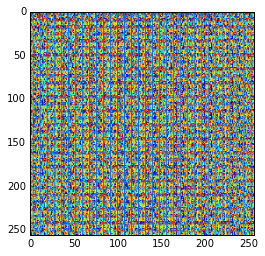

<class 'numpy.ndarray'>
(5, 256, 256)
(5, 256, 256, 1)
db: (5, 256, 256, 1)
Batch: (5, 256, 256, 1)
Batch Z: (5, 1)
Reached inside condition:steps % 1 ==0
Epoch 1/2... Discriminator Loss: 1.4892... Generator Loss: 0.9353
datashape3: 1
gen,z: (?, 1)
Gen,fully conn layer 1: (?, 524288)
Gen,fully conn layer 1 reshape: (?, 32, 32, 512)
Gen,deconv layer 1 : (?, 64, 64, 256)
Gen,deconv layer 2 : (?, 128, 128, 128)
Gen,output layer : (?, 256, 256, 1)
(1, 256, 256, 1)
(256, 256)


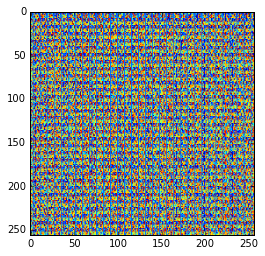

<class 'numpy.ndarray'>
(5, 256, 256)
(5, 256, 256, 1)
db: (5, 256, 256, 1)
Batch: (5, 256, 256, 1)
Batch Z: (5, 1)


KeyboardInterrupt: 

In [227]:
batch_size = 5
z_dim = 1
learning_rate = 0.0002
beta1 = 0.5
epochs = 2

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches, shape)